## 専門家知識の利用

多くの場合は専門家がルールを設計しなくてもいいようにモデル設計したいが、特定のアプリに事前知識を捨てるべきだということにはならない。専門家の知識が有用なことは多い。    
旅行代理店で航空運賃を予測したい場合。価格と日付と航空会社、出発地点を記録しているとする。これモデルは作れるが要素が足りてない。例えば運賃は休暇時間や祝日の周辺で高価になるので固定されていれば予測できる。しかし月の満ち欠けに依存して日程が決まる祭日（ハヌカー、イースター）や、権威者が決める休日は予測できない。しかしフライト休日の前日や翌日のデータを追加してみることはできる。

### 専門家知識を利用する例

レンタル自転車をレンタルの予測をする。これをするとオーナーはその日にレンタルできるかわかる。

In [1]:
%matplotlib inline
import mglearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

citibike = mglearn.datasets.load_citibike()

In [3]:
print("Citibike data:\n{}".format(citibike.head()))

Citibike data:
starttime
2015-08-01 00:00:00     3.0
2015-08-01 03:00:00     0.0
2015-08-01 06:00:00     9.0
2015-08-01 09:00:00    41.0
2015-08-01 12:00:00    39.0
Freq: 3H, Name: one, dtype: float64


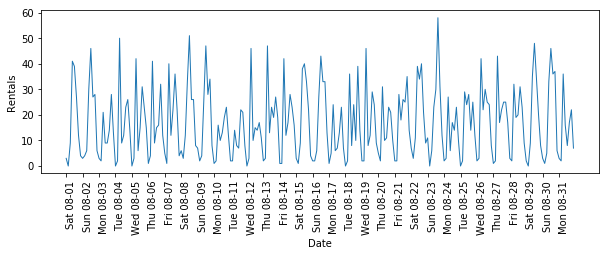

In [4]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")
plt.show()

昼と夜が明確にわかる。また、週末と平日も明確にパターンが異なる。    
このような時系列に対する予測タスクでは過去から学習、未来を予測するアプローチをとる。訓練データを作る際に、ある特定の日まで全てのデータを訓練データにし、それ以降をテストデータとする。

計算機で日時を格納するのにPOSIX時刻がよく使われる。1970年1月1日0時からの秒数でunix時刻とも言われる。

In [5]:
y = citibike.values
# 時刻はPOSIX時刻　エポック時刻に変換する
print(citibike.index[0])
print(citibike.index.astype("int64").values[0])
X = citibike.index.astype("int64").values.reshape(-1, 1)
print(X[0])

2015-08-01 00:00:00
1438387200000000000
[1438387200000000000]


In [6]:
#最初の184データポイントを学習データ、残りをテストデータ
n_train = 184

def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]

    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

ランダムフォレストはデータの前処理をほとんど必要としない。POSIX時間を特徴量Xとし、ランダムフォレスト回帰器とともにeval_on_features関数に与える

(248, 1)
Test-set R^2: -0.04


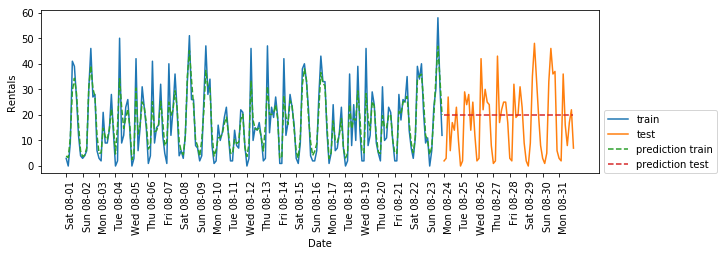

In [7]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
print(X.shape)
eval_on_features(X, y, regressor)
plt.show()

テストデータに対して予測できてない。R2が-0.04になり何も学習できてない。理由はposix時刻特徴量は訓練セット特徴量の値のレンジを外れている。テストデータのタイムスタンプは学習データの後ろだからだ。

ここで専門家知識が登場する。2つの要素が重要。1日の中の時間帯と曜日だ。まずは時間のみいれてみる。予測は曜日に関わらず同じパターンを描く。R2スコアはよくなってる

(248, 1)
Test-set R^2: 0.60


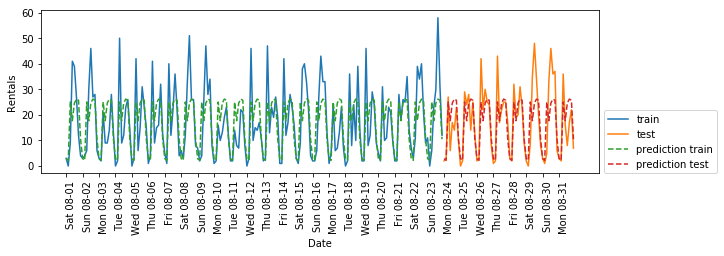

In [9]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
print(X_hour.shape)
eval_on_features(X_hour, y, regressor)
plt.show()

#残差を取る⇨差が大きい要因をモデル組みこむ

曜日を加えてみる。

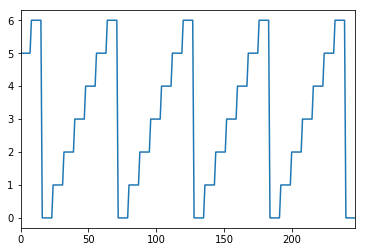

In [10]:
pd.Series(citibike.index.dayofweek.values).plot()

Test-set R^2: 0.84


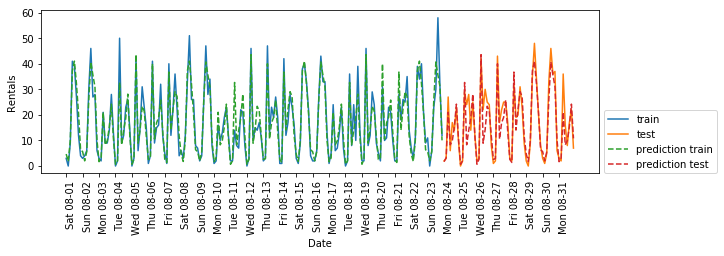

In [11]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)
plt.show()

曜日と時刻を考慮に入れた周期的な挙動を捉えたモデルができた。R2スコアもよくなった。    
このモデルは時刻の組み合わせに対する平均レンタル数を学習した。もっと簡単な線形回帰を使ってみる。

/Users/user/.pyenv/versions/miniconda3-3.10.1/envs/py35/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Test-set R^2: 0.13


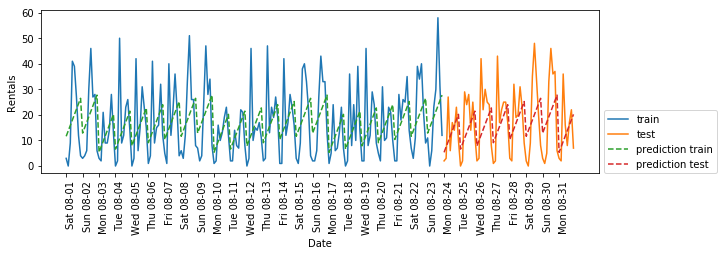

In [12]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())
plt.show()

性能は悪いし周期パターンもおかしい。曜日や時刻が整数でエンコードされていて、線形モデルの場合は連続値として解釈されているから時刻が遅いほどレンタル数が大きくなると学習してしまっている。OneHotEncoderで離散値へ変換する。

In [13]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


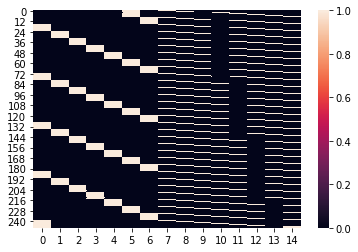

In [20]:
import seaborn as sns
sns.heatmap(pd.DataFrame(X_hour_week_onehot))
print(X_hour_week_onehot[80])

Test-set R^2: 0.62


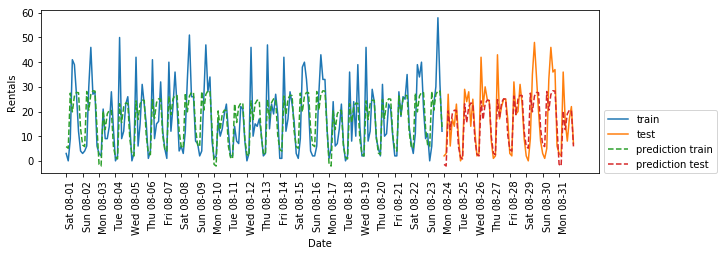

In [14]:
from sklearn.linear_model import Ridge
eval_on_features(X_hour_week_onehot, y, Ridge())
plt.show()

よくなったが、まだ足りない。交差作用特徴量を使って曜日と時刻の組み合わせに対して係数を学習。

[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


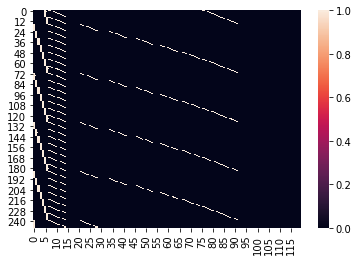

In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

import seaborn as sns
sns.heatmap(pd.DataFrame(X_hour_week_onehot_poly))
print(X_hour_week_onehot_poly[80])

Test-set R^2: 0.85


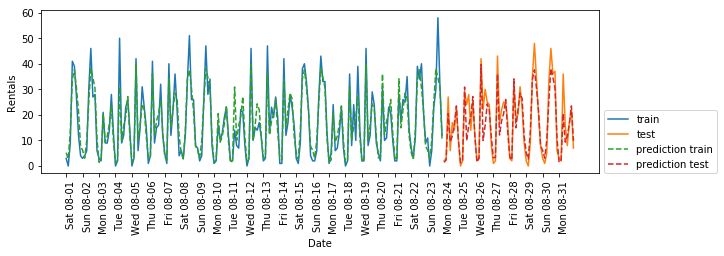

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)
plt.show()

この変換によってランダムフォレストと同等の性能になった。線形モデルの長所は何を学習したのか明確なこと。曜日と時刻の組み合わせに対して係数が１つずつ。ランダムフォレストにはできないが、線形モデルの係数をプロットしてみる。

In [13]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour

In [15]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

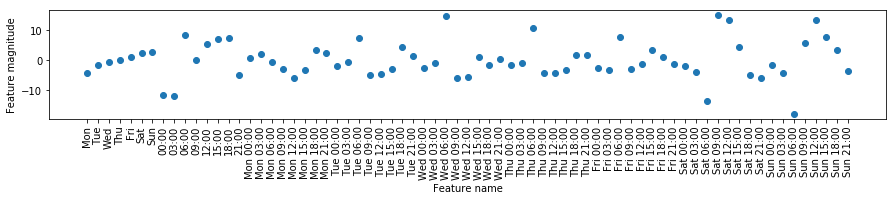

In [16]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")
plt.show()

時刻と曜日の積を用いた線形回帰モデルの係数。

# まとめ

- カテゴリ変数の数値化は連続値か離散値か注意して変換すること。    
- 専門家の知識で新しい特徴量を作るのも有用。    
- 線形モデルはビニングや多項式特徴量や交差作用特徴量の恩恵を受けやすい。    
- ランダムフォレストやSVMのように非線形なモデルでは明示的に特徴量空間を拡張することなくより複雑なタスクを学習できる。


# PolynomialFeatures

In [53]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

X = np.array([2,3]).reshape(-1, 1)
print("X:", X)
poly = PolynomialFeatures(2)
Y = poly.fit_transform(X)
print("Y:", Y)
print("poly.powers_:", poly.powers_)

X: [[2]
 [3]]
Y: [[1. 2. 4.]
 [1. 3. 9.]]
poly.powers_: [[0]
 [1]
 [2]]


In [48]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np

data = pd.DataFrame.from_dict({
    'x': np.random.randint(low=1, high=10, size=5),
    'y': np.random.randint(low=-1, high=1, size=5),
})

p = PolynomialFeatures(degree=2).fit(data)
print(p.get_feature_names(data.columns))
features = pd.DataFrame(p.transform(data), columns=p.get_feature_names(data.columns))
print(features)

['1', 'x', 'y', 'x^2', 'x y', 'y^2']
     1    x    y   x^2  x y  y^2
0  1.0  1.0 -1.0   1.0 -1.0  1.0
1  1.0  9.0  0.0  81.0  0.0  0.0
2  1.0  5.0 -1.0  25.0 -5.0  1.0
3  1.0  6.0 -1.0  36.0 -6.0  1.0
4  1.0  5.0 -1.0  25.0 -5.0  1.0


Pythonで多項式回帰
http://retrofocus28.blogspot.jp/2015/06/python.html    
高次の多項式は書くのが大変。PolynomialFeaturesは自動計算できる。

In [32]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [37]:
#original function
def original_function(x):
    return 2*x[0]**2 + 3*x[0]*x[1] + 4*x[1]**2 + 2*x[0] + 3*x[1] + 4


In [38]:
#observed data
xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
X = np.vstack((xx.reshape(-1), yy.reshape(-1))).T
y = list(map(original_function, X))

In [39]:
#fit the data
degree = 2
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(X, y)


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [40]:
#accessing to the coeffs
#(model is a Pipeline.)
print(model.steps[1][1].coef_)

[0.         1.98780212 2.98170319 1.99033898 2.98874589 3.98067795]


# map

In [44]:
X = [3,2,3]
list(map(lambda x : x + 1, X))

[4, 3, 4]